In [1]:
from dotenv import load_dotenv
import os
import logging

logging.basicConfig(level=logging.INFO)
load_dotenv()
GROQ_API_KEY = os.getenv('GROQ_API_KEY')


print(f'Is my GROQ_API_KEY None -- {GROQ_API_KEY is None}')

Is my GROQ_API_KEY None -- False


In [2]:
##Pull the model of your choice using groq

from langchain_groq import ChatGroq
llm = ChatGroq(
    model_name='llama-3.1-8b-instant',
    groq_api_base=None, ##No proxy defined
    groq_api_key=GROQ_API_KEY, 
    streaming=False,
    verbose=True ##For logging purposes
)


In [3]:
##Build the logic for doing Wkikipedia search
from langchain_community.retrievers import WikipediaRetriever
##Tweak top_k_results as needed

##Top 1st document
wikipedia_retreiver = WikipediaRetriever(doc_content_chars_max = 1000000, top_k_results = 1, load_all_available_meta=False)


##Build the logic for Arxiv search
from langchain_community.utilities.arxiv import ArxivAPIWrapper
from langchain_community.tools.arxiv import ArxivQueryRun

arxiv_obj = ArxivAPIWrapper(doc_content_chars_max=10000, top_k_results=1)
arxiv_search = ArxivQueryRun(api_wrapper=arxiv_obj)


In [4]:
##Define the step state - Think of it like a return type for the search in total
from typing import TypedDict, Union

##WikipedaStep
class SearchStep(TypedDict):
    topic : str
    search_results_arxiv : Union[str, None]
    search_results_wikipedia : Union[str, None]
    summary: str
    metasummary:str
        

In [5]:
def search_wikipedia(step:SearchStep):
    topic_of_interest = step['topic'][-1].content
    
    try:
        logging.info('Searching Wikipedia....')
        response = wikipedia_retreiver.invoke(topic_of_interest)[0].page_content
        return {**step,
              "topic":step['topic'],  ##Hold the history
              "search_results_wikipedia": response,
               "search_results_arxiv": step['search_results_arxiv'],
               "summary":""}
    except:
        logging.warning('Wikipedia search failed. Retuning empty artifacts')
        return {**step, 
              "topic":step['topic'],
              "search_results_wikipedia":None,
               "search_results_arxiv": step['search_results_arxiv'],
               "summary":""}
        
        
    

In [6]:
def search_arxiv(step:SearchStep):
    topic_of_interest = step['topic'][-1].content
    
    try:
        logging.info('Searching Arxvi')
        response = arxiv_search.invoke(topic_of_interest)   ##Returns the summary of the page
        return {**step,
               "topic":step['topic'],
               "search_results_arxiv":response,
               "search_results_wikipedia": step['search_results_wikipedia'],
               "summary":""}
    except:
        logging.warning('Arxiv search failed')
        return {**step,
               "topic": step['topic'],
               "search_results_arxiv": None,
               "search_results_wikipedia" : step['search_results_wikipedia'],
               "summary":""}

In [7]:
def summarize_search_results(step:SearchStep):
    
    wiki_results = step.get('search_results_wikipedia')
    arxiv_results = step.get('search_results_arxiv')

    ##Add a summarization step before since you cannot tweak context window
    wiki_summary = llm.invoke(f'Give me 5 key takeways from {wiki_results}', temperature=0.1)
    arxiv_summary = llm.invoke(f'Give me 5 key takeawaya from {arxiv_results}', temperature=0.1)

    concated_results = wiki_summary + arxiv_summary
    
    logging.info('Invoking the chosen llm')
    
    #Tweak the context window as required - Just doing twice summarization due to lack of way to tweak context window
    llm_summary = llm.invoke(f'Summarize the given content and give me 5 key takeaways each from {concated_results}. Assume that the \
    target audience is novice in this domain. DO NOT ignore any content', temperature=0.1 )
    final_summary = llm_summary.content
    
    return {**step, "summary":final_summary, "metasummary":concated_results}
    

    
    

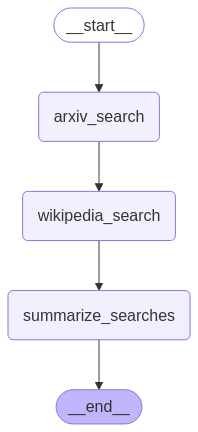

In [8]:
##Print the worklfow
from IPython.display import display, Image
from langgraph.graph import StateGraph

workflow = StateGraph(SearchStep)

workflow.add_node("arxiv_search", search_arxiv)
workflow.add_node("wikipedia_search", search_wikipedia)
workflow.add_node("summarize_searches", summarize_search_results)

workflow.add_edge("__start__", "arxiv_search")

workflow.add_edge("arxiv_search", "wikipedia_search")
workflow.add_edge("wikipedia_search", "summarize_searches")
workflow.add_edge("summarize_searches","__end__")

graph = workflow.compile()

Image(graph.get_graph().draw_mermaid_png())


In [9]:
from langchain_core.messages import HumanMessage


query = HumanMessage(input())
initial_state = {
    
    "topic": [query],
    "search_results_arxiv": None,
    "search_results_wikipedia": None,
    "summary":''
    
}
response = graph.invoke(initial_state)



 Rashomon Effect


INFO:root:Searching Arxvi
INFO:arxiv:Requesting page (first: True, try: 0): https://export.arxiv.org/api/query?search_query=Rashomon+Effect&id_list=&sortBy=relevance&sortOrder=descending&start=0&max_results=100
INFO:arxiv:Got first page: 100 of 566838 total results
INFO:root:Searching Wikipedia....
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Invoking the chosen llm
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [10]:
print(response['summary'])

**Summary:**

The provided content discusses the Rashomon effect, a concept that highlights the unreliability of eyewitnesses and the subjective nature of human perception, memory, and reporting. It emphasizes the importance of considering multiple perspectives and interpretations of an event, rather than relying on a single, objective truth. The Rashomon effect is particularly relevant in situations where events are complex and ambiguous. Two separate sources discuss the Rashomon effect in the context of eyewitness accounts and machine learning models.

**5 Key Takeaways from the First Source:**

1. **Unreliability of eyewitnesses**: The Rashomon effect highlights the unreliability of eyewitnesses and the subjective nature of human perception, memory, and reporting.
2. **Subjectivity vs. objectivity**: The Rashomon effect emphasizes the subjective nature of human perception and the difficulty of achieving objectivity in reporting and understanding complex events.
3. **Multiple perspec

In [11]:
response.keys()

dict_keys(['topic', 'search_results_arxiv', 'search_results_wikipedia', 'summary', 'metasummary'])